In [ ]:
''' Polygon '''

In [34]:
import fiona
import geopandas
import shapely.speedups
from shapely import geometry
from shapely.geometry import shape, mapping

In [59]:
import matplotlib.pyplot as plt

In [35]:
%ls

DAS-PGMEI-49317655000187-AC2023.pdf  shapely.object.difference.ipynb
example_buffers.gpkg                 shapely.object.difference.py
example_buffers_difference.gpkg


In [92]:
input_filename = "example_buffers.gpkg"

output_filename = "example_buffers_difference.gpkg"

In [37]:
with fiona.open(input_filename, mode='r') as input_geopackage:
    input_layers = fiona.listlayers(input_filename)

In [38]:
input_layers

['exampleESRI102032', 'exampleESRI102032_buffer1']

In [50]:
input_layer1 = input_layers[0]

In [54]:
with fiona.open(input_filename, mode='r', layer=input_layer1) as layer1:
	layer1_polygons = [shape(element['geometry']) for element in list(layer1)]	# Collection (fiona.collection.Collection) to list of polygons
	layer1_geoseries = geopandas.GeoSeries(layer1_polygons)

<AxesSubplot: >

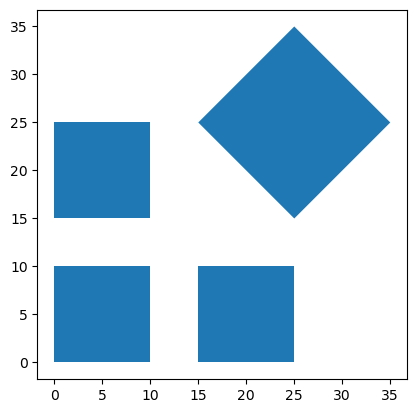

In [55]:
layer1_geoseries.plot()

In [56]:
input_layer2 = input_layers[1]

In [57]:
with fiona.open(input_filename, mode='r', layer=input_layer2) as layer2:
	layer2_polygons = [shape(element['geometry']) for element in list(layer2)]	# Collection (fiona.collection.Collection) to list of polygons
	layer2_geoseries = geopandas.GeoSeries(layer2_polygons)		# list of polygons to GeoSeries

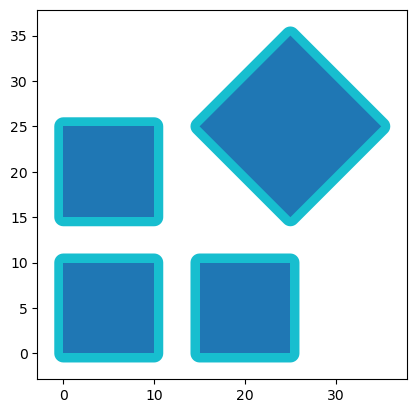

In [97]:
fig, ax = plt.subplots()
layer2_geoseries.plot(ax=ax, color='tab:cyan')
layer1_geoseries.plot(ax=ax, color='tab:blue')
plt.show()

In [66]:
layer1_geoseries.sindex		# create spatial index

layer2_geoseries.sindex		# create spatial index

In [67]:
layer1_geodataframe = geopandas.GeoDataFrame(geometry=layer1_geoseries)

layer2_geodataframe = geopandas.GeoDataFrame(geometry=layer2_geoseries)

In [69]:
layer1_geoseries.index = geopandas.sjoin(layer1_geodataframe, layer2_geodataframe, how='left', predicate='within').index_right

# layer2_geoseries.index = geopandas.sjoin(layer2_geodataframe, layer0_geodataframe, how='left', predicate='Contains').index_right

In [88]:
difference_polygons = [polygon2.difference(layer1_geoseries[i]) for i, polygon2 in enumerate(layer2_polygons)]

<AxesSubplot: >

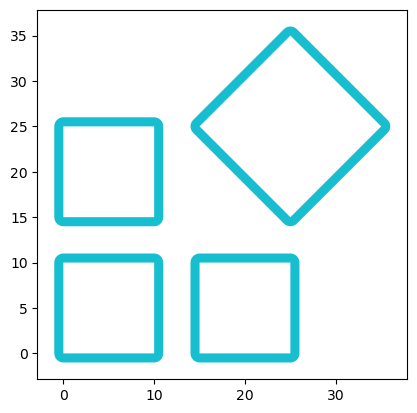

In [98]:
geopandas.GeoDataFrame(geometry=difference_polygons).plot(color='tab:cyan')

In [93]:
# Cast to MultiPolygon

from shapely.geometry.multipolygon import MultiPolygon

def cast_to_multipolygon(geom):
	if type(geom) == geometry.polygon.Polygon:
		return geometry.multipolygon.MultiPolygon([geom])
    
difference_multipolygons = list(map(cast_to_multipolygon, difference_polygons))

In [94]:
output_layer = input_layer2

schema = {
	"geometry": "MultiPolygon", "properties": {"id": "int"}
}

with fiona.open(output_filename, mode='w', driver='GPKG', schema=schema, crs='ESRI:102032', layer=output_layer) as output_geopackage:
	for id, geoms in enumerate(difference_multipolygons):
		output_geopackage.write({"geometry": mapping(geoms), "properties": {"id": id}})